In [363]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import math

# visualizations
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics, preprocessing

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

KUMPULAN FUNGSI

In [364]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [365]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res['inv_'+str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [366]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), ' > ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [367]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')

INPUT DATA

In [368]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'
print(dataTA.shape) 
dataTA.head()

(120, 4)


,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-01-01,436.0,23.06,77.55,2.80
2012-02-01,493.0,23.50,78.69,6.33
2012-03-01,519.0,23.50,74.48,5.33
2012-04-01,482.0,24.00,81.00,3.00
2012-05-01,573.0,23.60,77.23,6.75


VISUAL DATA

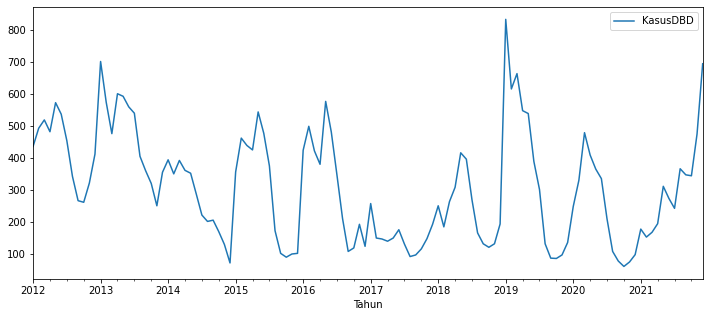

In [369]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

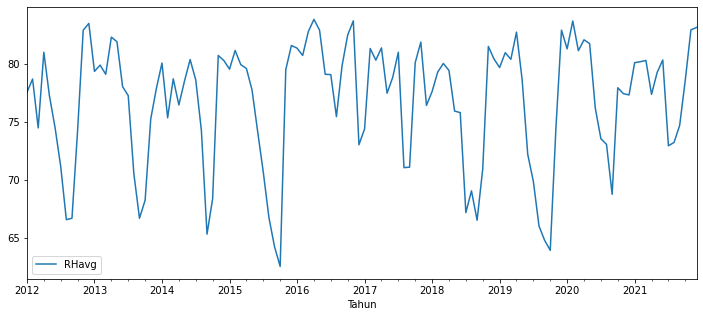

In [370]:
ylabel= ' '
xlabel= 'Tahun'
ax = dataTA['RHavg'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)

In [371]:
data=dataTA[['KasusDBD', 'RHavg']]
data.columns = ['KasusDBD', 'RHavg']
data.tail(24)

,KasusDBD,RHavg
Tahun,,
2020-01-01,248.0,81.29
2020-02-01,330.0,83.69
2020-03-01,479.0,81.13
2020-04-01,409.0,82.07
2020-05-01,365.0,81.74
2020-06-01,335.0,76.20
2020-07-01,209.0,73.55
2020-08-01,107.0,73.06
2020-09-01,77.0,68.76


UJI KORELASI

In [372]:
data.corr()

,KasusDBD,RHavg
KasusDBD,1.000000,0.315865
RHavg,0.315865,1.000000


NORMALISASI DATA

In [373]:
max_kasus = data['KasusDBD'].max()
max_kelembapan = data['RHavg'].max()


In [374]:
data['KasusDBD'] = data['KasusDBD']/max_kasus
data['RHavg'] = data['RHavg']/max_kelembapan
data

C:\Users\asus\AppData\Local\Temp\ipykernel_22708\1201687390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['KasusDBD'] = data['KasusDBD']/max_kasus
C:\Users\asus\AppData\Local\Temp\ipykernel_22708\1201687390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RHavg'] = data['RHavg']/max_kelembapan


,KasusDBD,RHavg
Tahun,,
2012-01-01,0.522782,0.925086
2012-02-01,0.591127,0.938685
2012-03-01,0.622302,0.888465
2012-04-01,0.577938,0.966241
2012-05-01,0.687050,0.921269
...,...,...
2021-08-01,0.438849,0.873554
2021-09-01,0.416067,0.891089
2021-10-01,0.412470,0.937731


UJI STASIONER

In [375]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                  -2.621707
p-value                          0.088593
No Lags Used                    13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




TRAIN TEST SPLIT

In [376]:
n = 3
train,test = data[0:-n], data[-n:]
train_diff=train.diff(periods=2)
train_diff.dropna(inplace=True)
train_diff

,KasusDBD,RHavg
Tahun,,
2012-03-01,0.099520,-0.036622
2012-04-01,-0.013189,0.027556
2012-05-01,0.064748,0.032804
2012-06-01,0.065947,-0.077538
2012-07-01,-0.142686,-0.072408
...,...,...
2021-05-01,0.172662,-0.012287
2021-06-01,0.094724,0.035310
2021-07-01,-0.082734,-0.075391


In [377]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.200822
p-value                          0.000657
No Lags Used                    10.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                -8.757188e+00
p-value                        2.735192e-14
No Lags Used                   9.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




In [378]:
cointegration_test(train_diff[['KasusDBD','RHavg']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KasusDBD  >  93.6      > 12.3212   =>   True
RHavg   >  33.33     > 4.1296    =>   True


Text(0.5, 1.0, 'Partial Autocorrelation Function KasusDBD')

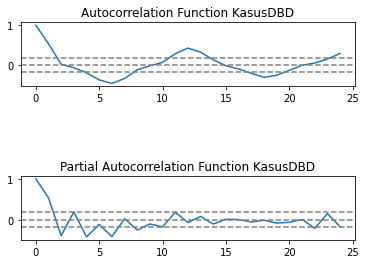

In [379]:
#KASUS DBD
kasusDBD_acf = acf(train_diff['KasusDBD'], nlags=24)
kasusDBD_pacf = pacf(train_diff['KasusDBD'], nlags=24, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(kasusDBD_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function KasusDBD')

#Plot PACF:
plt.subplot(313)
plt.plot(kasusDBD_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['KasusDBD'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function KasusDBD')

Text(0.5, 1.0, 'Partial Autocorrelation Function RHAVG')

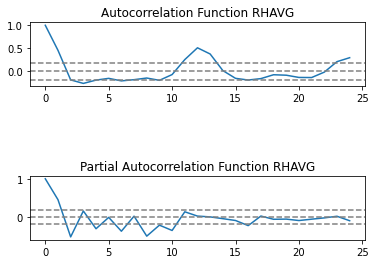

In [380]:
#RHAVG
rhavg_acf = acf(train_diff['RHavg'], nlags=24)
rhavg_pacf = pacf(train_diff['RHavg'], nlags=24, method='ols')

#Plot ACF: 
plt.subplot(311) 
plt.plot(rhavg_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['RHavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['RHavg'])),linestyle='--',color='gray')
plt.title(f'Autocorrelation Function RHAVG')

#Plot PACF:
plt.subplot(313)
plt.plot(rhavg_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff['RHavg'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff['RHavg'])),linestyle='--',color='gray')
plt.title(f'Partial Autocorrelation Function RHAVG')

AUTO ARIMA

In [381]:
pq = []
for name, column in train_diff[['KasusDBD', 'RHavg']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=6, max_q=6, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-53.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-90.393, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-106.089, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-108.406, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-126.498, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-125.778, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-124.530, Time=0.22 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 2.792 seconds
optimal order for:KasusDBD is: (4, 0, 0) 


Searching order of p and q fo

VARMA MODEL ORDER SELECTION

In [382]:
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        model = VARMAX(train_diff, order=(i[0],i[2]))
        result=model.fit( disp=False)
        print(f'VARMA Order {i}')
        print('AIC {}'.format(result.aic))
        print('BIC {}'.format(result.bic))
        print()


c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (4, 0, 0)
AIC -508.048524300885
BIC -450.4049496052567



c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA Order (4, 0, 1)
AIC -507.2160092762375
BIC -438.59270606715626



In [383]:
varma_model = VARMAX(train_diff[['KasusDBD','RHavg']], order=(4,0),enforce_stationarity= True)
fitted_model = varma_model.fit(disp=False)
print(fitted_model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                            
Dep. Variable:     ['KasusDBD', 'RHavg']   No. Observations:                  115
Model:                            VAR(4)   Log Likelihood                 275.024
                             + intercept   AIC                           -508.049
Date:                   Thu, 18 Aug 2022   BIC                           -450.405
Time:                           15:10:47   HQIC                          -484.651
Sample:                       03-01-2012                                         
                            - 09-01-2021                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.02, 0.06   Jarque-Bera (JB):         121.84, 1.03
Prob(Q):                        0.88, 0.81   Prob(JB):                   0.00, 0.60
Heteroskedasticity (H):         1.87, 1.33   Skew:                       1.01, 0.18
Prob(H) (t

PREDIKSI KASUS DBD

In [384]:
m = len(train_diff)
predict = fitted_model.get_prediction(start=m,end=m+n-1)
prediction=predict.predicted_mean
prediction

,KasusDBD,RHavg
2021-10-01,-0.115909,0.046816
2021-11-01,-0.058062,0.008908
2021-12-01,0.090001,-0.007144


In [385]:
inv_predict = inverse_diff(data,prediction)
inv_predict

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
2021-10-01,-0.115909,0.046816,0.717424,1.038466
2021-11-01,-0.058062,0.008908,0.659362,1.047375
2021-12-01,0.090001,-0.007144,0.749362,1.040230


In [386]:
test_vs_prediction = pd.concat([test,inv_predict[['inv_KasusDBD','inv_RHavg']]],axis=1)
test_vs_prediction

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
2021-10-01,0.412470,0.937731,0.717424,1.038466
2021-11-01,0.569544,0.989264,0.659362,1.047375
2021-12-01,0.833333,0.991650,0.749362,1.040230


MENGEMBALIKAN NILAI ASLI

In [387]:
test_vs_prediction['inv_KasusDBD'] = test_vs_prediction['inv_KasusDBD']*max_kasus
test_vs_prediction['inv_RHavg'] = test_vs_prediction['inv_RHavg']*max_kelembapan
test_vs_prediction['KasusDBD'] = test_vs_prediction['KasusDBD']*dataTA['KasusDBD'].max()
test_vs_prediction['RHavg'] = test_vs_prediction['RHavg']*dataTA['RHavg'].max()
test_vs_prediction

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
2021-10-01,344.0,78.61,598.331536,87.054617
2021-11-01,475.0,82.93,549.907544,87.801412
2021-12-01,695.0,83.13,624.968061,87.202516


CONVERTING PREDICTION FROM FLOAT TO INTEGER

In [388]:
# converting 'test_vs_prediction' from float to int
test_vs_prediction[['inv_KasusDBD']] = test_vs_prediction[['inv_KasusDBD']].apply(np.int64)

# displaying the datatypes
display(test_vs_prediction.dtypes)
test_vs_prediction

KasusDBD        float64
RHavg           float64
inv_KasusDBD      int64
inv_RHavg       float64
dtype: object

,KasusDBD,RHavg,inv_KasusDBD,inv_RHavg
2021-10-01,344.0,78.61,598,87.054617
2021-11-01,475.0,82.93,549,87.801412
2021-12-01,695.0,83.13,624,87.202516


In [389]:
for i in ['KasusDBD','RHavg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test_vs_prediction[str(i)] , test_vs_prediction['inv_'+str(i)])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 25011.0
MAE is : 133.0
RMSE is : 158.14866423716643
MAPE is : 0.3321066133629204

Evaluation metric for RHavg
Evaluation metric results:-
MSE is : 37.20919703327607
MAE is : 5.796181388552895
RMSE is : 6.09993418270034
MAPE is : 0.07171839224414195



<AxesSubplot:>

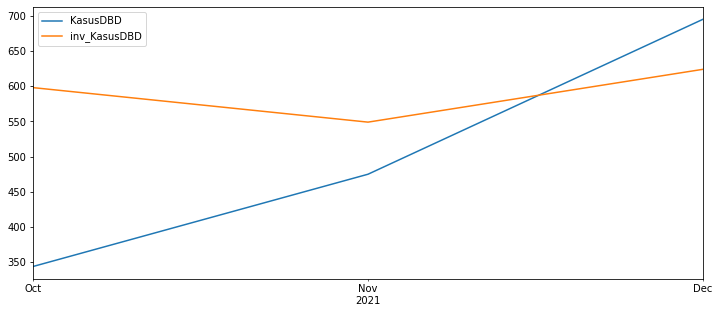

In [390]:
test_vs_prediction[['KasusDBD','inv_KasusDBD']].plot(figsize=(12,5))

<AxesSubplot:>

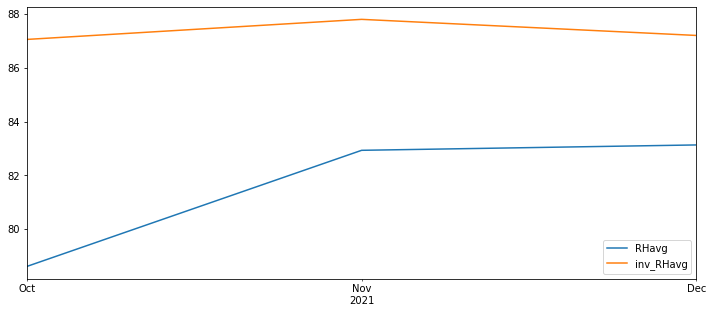

In [391]:
test_vs_prediction[['RHavg','inv_RHavg']].plot(figsize=(12,5))

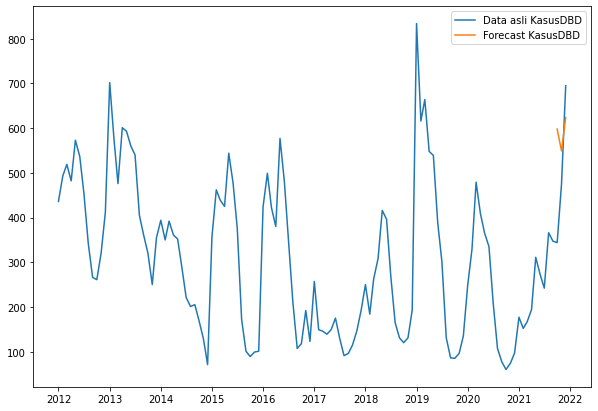

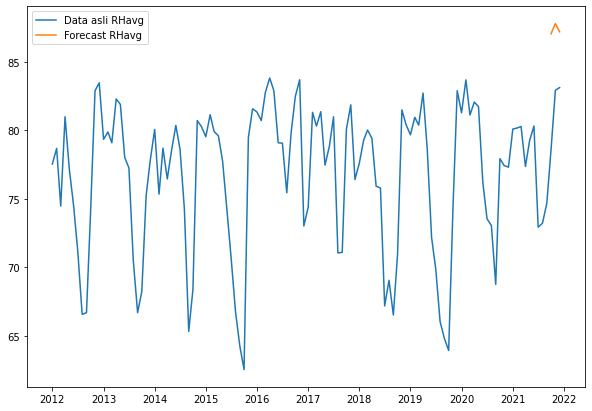

In [392]:
for i in ['KasusDBD','RHavg']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(dataTA[str(i)], label='Data asli '+str(i))
    plt.plot(test_vs_prediction['inv_'+str(i)], label='Forecast '+str(i))
    plt.legend(loc='best')
    plt.show()